# Abalone: Exploratory Data Analysis

The data was downloaded using the `ucimlrepo` module (see `get-data.py` script) and is stored in `data/abalone.csv`.

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ucimlrepo import fetch_ucirepo

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

plt.style.use('ggplot')

DATA_DIR = 'data/'

In [2]:
# read the data
abalone = pd.read_csv(DATA_DIR + 'abalone.csv')
abalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## Variables and Project Goals

In [3]:
fetch_ucirepo(id=1).variables

,name,role,type,demographic,description,units,missing_values
0,Sex,Feature,Categorical,None,"M, F, and I (infant)",None,no
1,Length,Feature,Continuous,None,Longest shell measurement,mm,no
2,Diameter,Feature,Continuous,None,perpendicular to length,mm,no
3,Height,Feature,Continuous,None,with meat in shell,mm,no
4,Whole_weight,Feature,Continuous,None,whole abalone,grams,no
5,Shucked_weight,Feature,Continuous,None,weight of meat,grams,no
6,Viscera_weight,Feature,Continuous,None,gut weight (after bleeding),grams,no
7,Shell_weight,Feature,Continuous,None,after being dried,grams,no
8,Rings,Target,Integer,None,+1.5 gives the age in years,None,no


In [4]:
metadata = fetch_ucirepo(id=1).metadata
metadata.additional_info.summary

'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- a boring and time-consuming task.  Other measurements, which are easier to obtain, are used to predict the age.  Further information, such as weather patterns and location (hence food availability) may be required to solve the problem.\r\n\r\nFrom the original data examples with missing values were removed (the majority having the predicted value missing), and the ranges of the continuous values have been scaled for use with an ANN (by dividing by 200).'

In [5]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


The info shows us that the data does not have any missing values. Most of the data is numeric - the **Sex** feature will be converted to numerical through label encoding in the **Feature Engineering** section (relevant for model development).

We see that the age in years is found by adding 1.5 to the `Rings` column. Let's create the age column:

In [6]:
abalone['Age'] = abalone['Rings'] + 1.5
abalone = abalone.drop('Rings', axis=1)

We also see that the original measurements of the continuous variables are obtained by multiplying the data by 200. To get a better feel for the data, let us rescale the contiunuous variables:

In [7]:
abalone.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
Age               float64
dtype: object

In [8]:
float_columns = abalone.select_dtypes(include=['float64']).columns
# the age column should not be multiplied
float_columns = float_columns.drop('Age')
abalone[float_columns] = abalone[float_columns] * 200
abalone.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
0,M,91.0,73.0,19.0,102.8,44.9,20.2,30.0,16.5
1,M,70.0,53.0,18.0,45.1,19.9,9.7,14.0,8.5
2,F,106.0,84.0,27.0,135.4,51.3,28.3,42.0,10.5
3,M,88.0,73.0,25.0,103.2,43.1,22.8,31.0,11.5
4,I,66.0,51.0,16.0,41.0,17.9,7.9,11.0,8.5


In [9]:
abalone.describe()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,104.798420,81.576251,27.903280,165.748432,71.873498,36.118722,47.766172,11.433684
std,24.018583,19.847973,8.365411,98.077804,44.392590,21.922850,27.840534,3.224169
min,15.000000,11.000000,0.000000,0.400000,0.200000,0.100000,0.300000,2.500000
25%,90.000000,70.000000,23.000000,88.300000,37.200000,18.700000,26.000000,9.500000
50%,109.000000,85.000000,28.000000,159.900000,67.200000,34.200000,46.800000,10.500000
75%,123.000000,96.000000,33.000000,230.600000,100.400000,50.600000,65.800000,12.500000
max,163.000000,130.000000,226.000000,565.100000,297.600000,152.000000,201.000000,30.500000


## Let's look at some interesting features

### Distribution of the data across gender

In [10]:
# define colors for genders across the notebook
colors = ['blue', 'red', 'green']
genders = abalone['Sex'].unique()
colormap = {sex: color for sex, color in zip(genders, colors)}

In [11]:
grouped_by_sex = abalone.groupby(['Sex'])

<Axes: xlabel='Sex'>

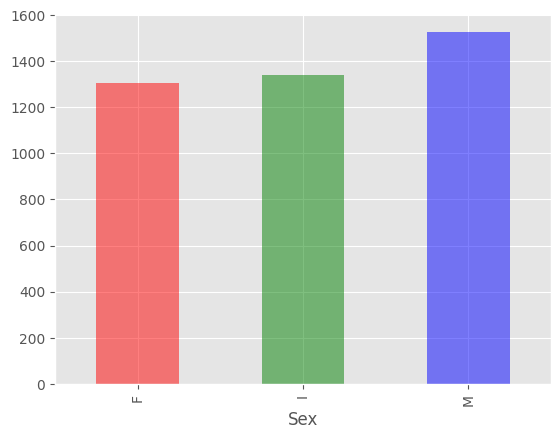

In [12]:
# get colors in the order of grouped data
bar_colors = [colormap[sex] for sex in grouped_by_sex.groups.keys()]

# plot the size of each group
grouped_by_sex.size().plot(kind='bar', color=bar_colors, alpha=0.5)

We can also look at the mean of the numeric values across the different genders:

In [13]:
grouped_by_sex.mean()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Age
Sex,,,,,,,,
F,115.818669,90.946442,31.602142,209.306427,89.237567,46.137720,60.401989,12.629304
I,85.549180,65.298808,21.599106,86.272504,38.207004,18.402012,25.636438,9.390462
M,112.278141,87.857330,30.276178,198.291885,86.589202,43.108901,56.393848,12.205497


<Axes: xlabel='Sex', ylabel='Numeric Value'>

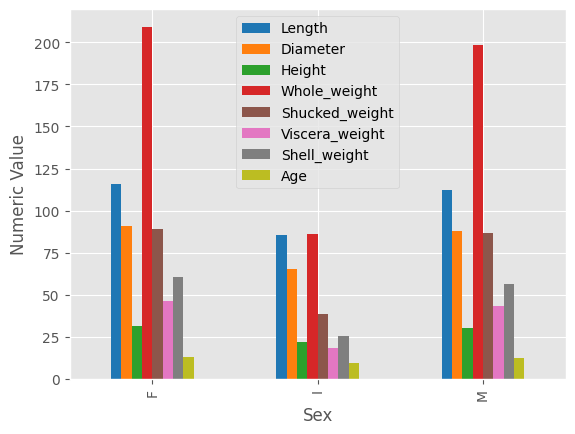

In [14]:
cmap = plt.get_cmap('tab10')
n = len(abalone.columns.drop('Sex'))
feature_colors = [cmap(i/n) for i in range(n)]
grouped_by_sex.mean().plot(kind='bar', ylabel='Numeric Value', color=feature_colors)

We see that the female abalones on average are bigger and heavier than their male counterparts.

Another interesting feature to look at is distribution of age (number of rings + 1.5) across the different genders:

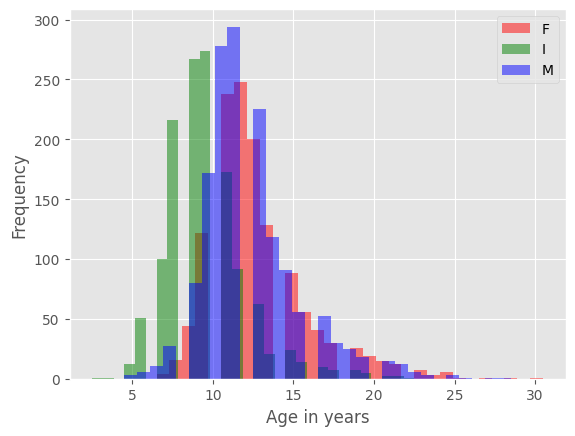

In [19]:
for key, group in grouped_by_sex:
    key = str(key).strip("('',)") 
    group['Age'].plot(kind='hist', xlabel='Age in years', label=key, legend=True, alpha=0.5, bins=30, color=colormap[key])
plt.show()

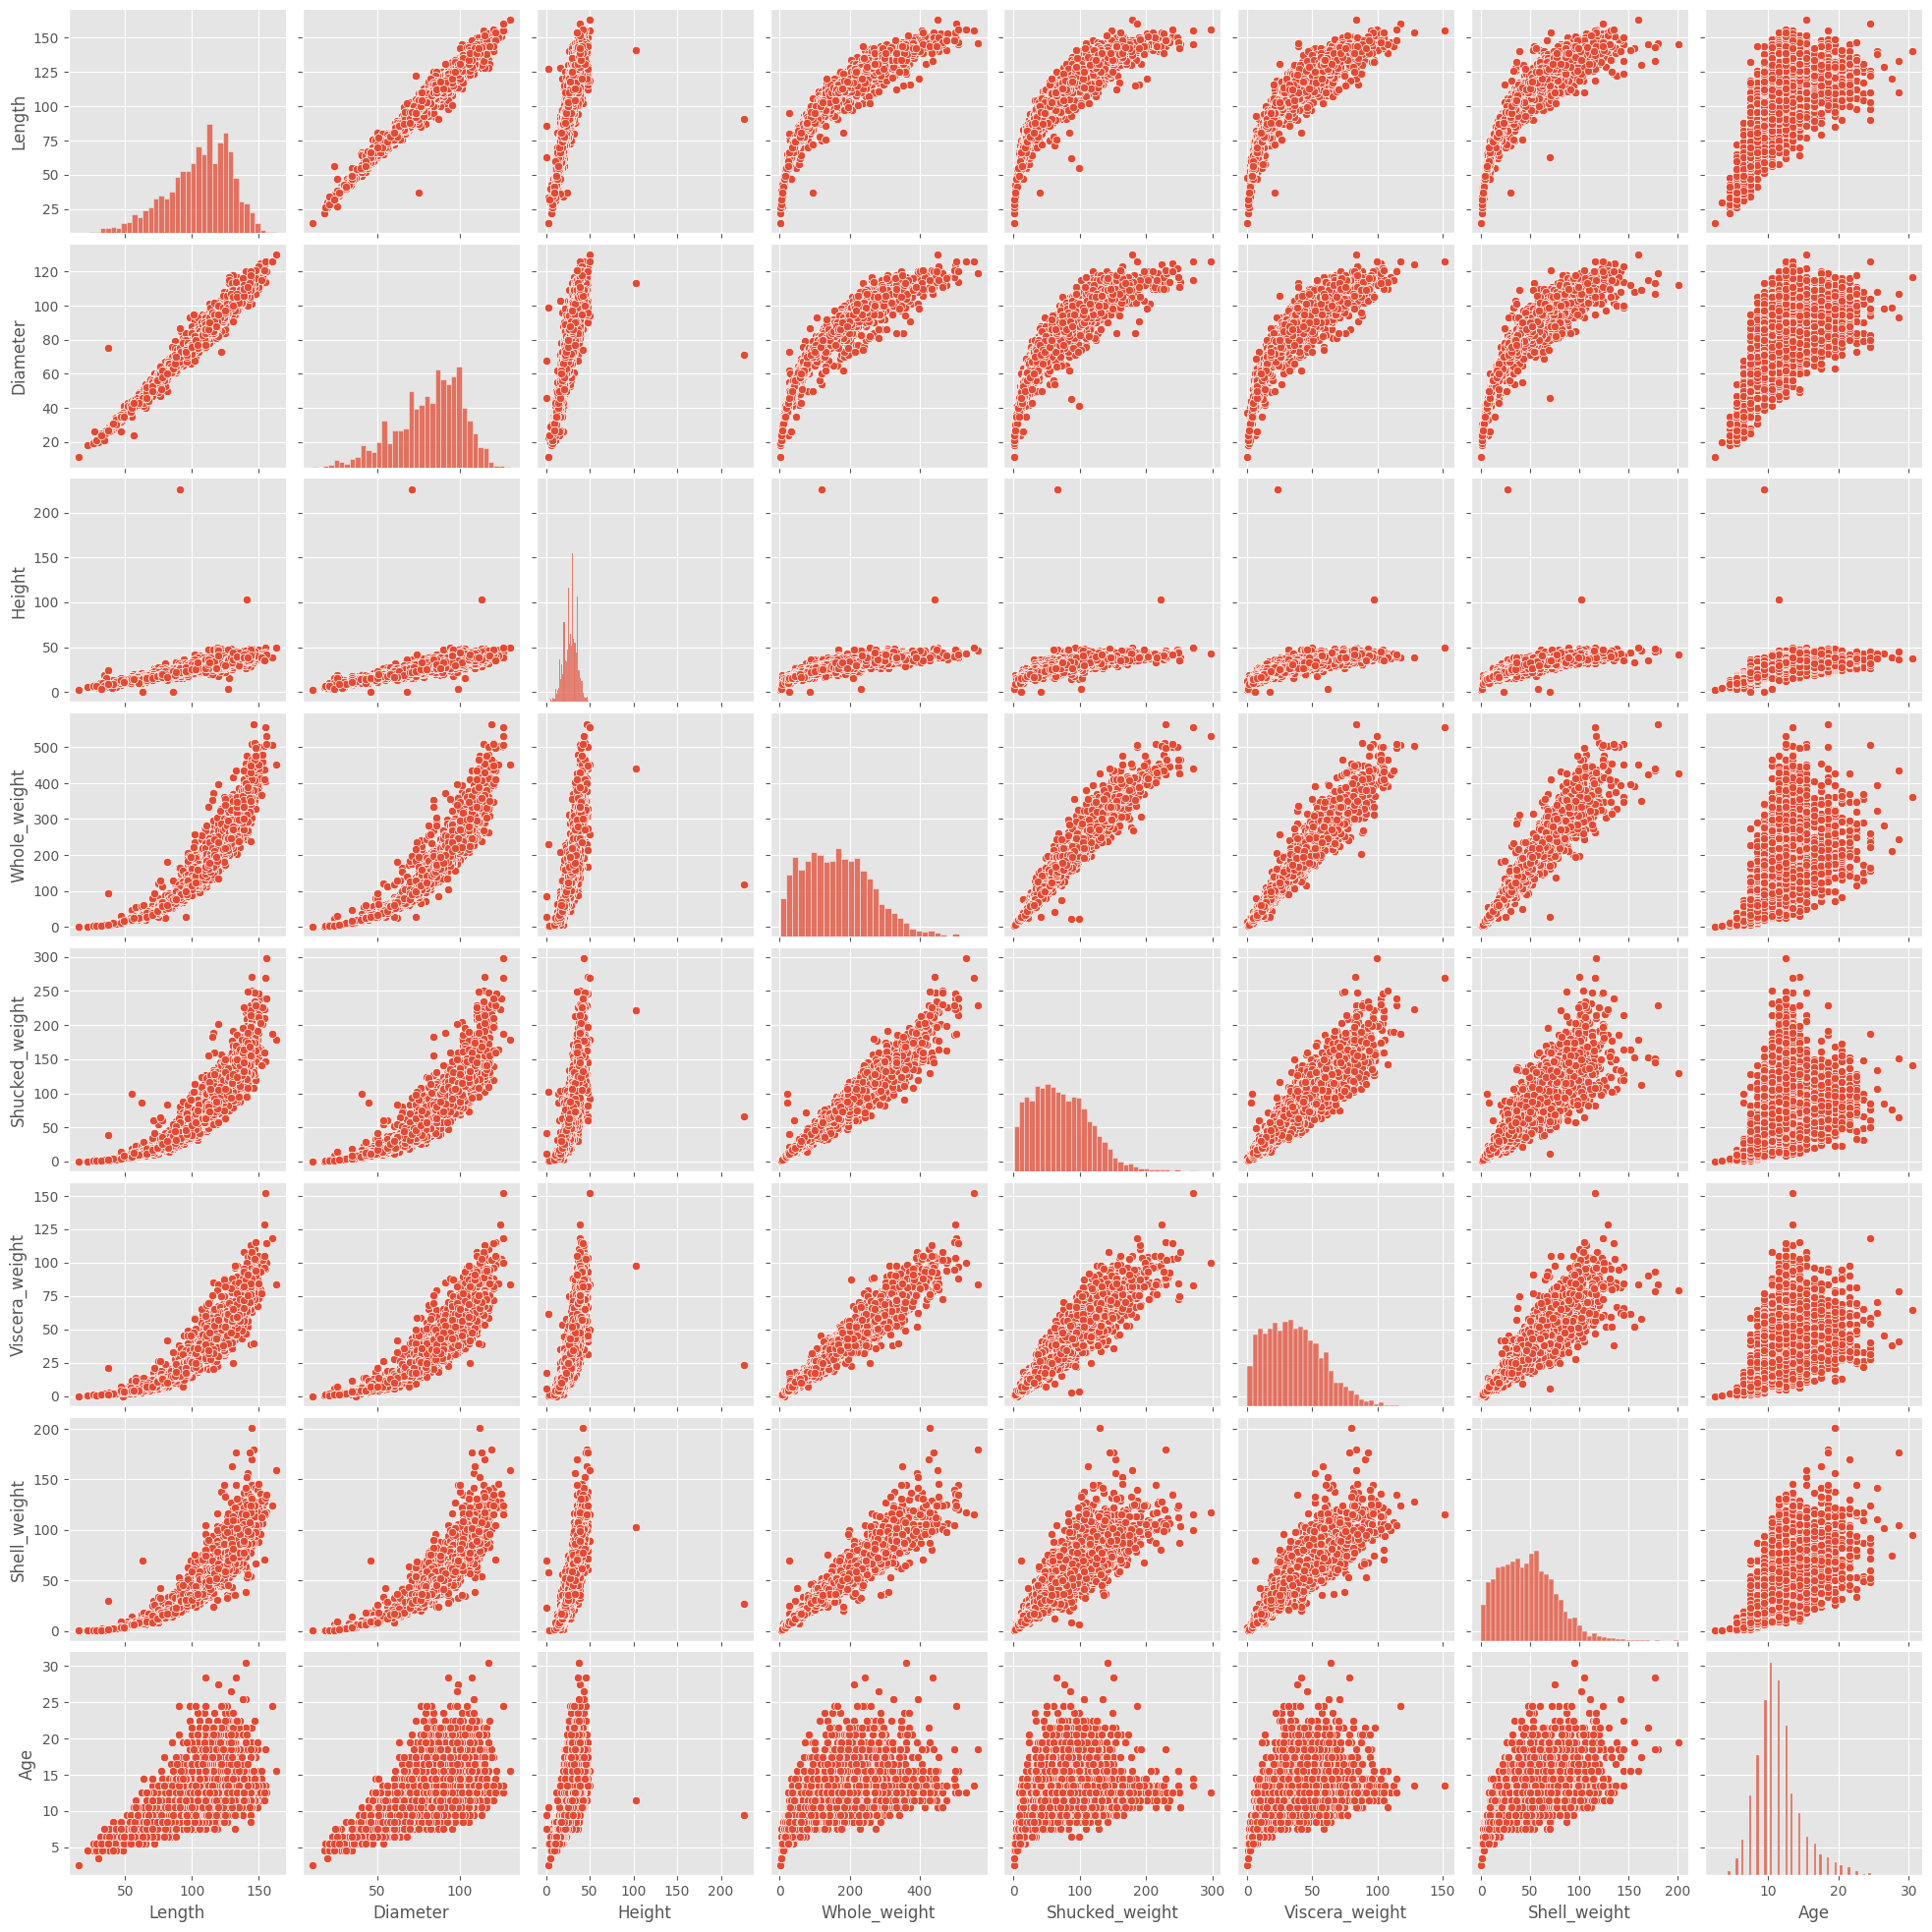

In [18]:
sns.pairplot(abalone.drop(['Sex'], axis=1))

Some thoughts: 

We see that 